<a href="https://colab.research.google.com/github/rafaeljosem/MNA-ProyectoIntegrador_EQ10/blob/main/Avance-6/Avance6_Equipo10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

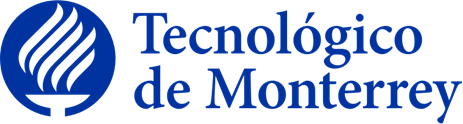

# **Maestría en Inteligencia Artificial Aplicada**
## **Curso: Proyecto Integrador**

### Dra. Grettel Barceló Alonso
### Dr. Luis Eduardo Falcón Morales
### Mtra. Verónica Sandra Guzmán de Valle

## **Avance 6: Modelo Final**

### Domingo 2 de junio de 2024

## **Nombres y matrículas de los integrantes del Equipo 10:**

* Fernando Maytorena Espinosa de los Monteros | A01110946
* Jonathan Garza Bennet | A01793038
* Rafael José Mateo Comprés | A01793054

To run this, press "*Runtime*" and press "*Run all*" on a **free** Tesla T4 Google Colab instance!
<div class="align-center">
  <a href="https://github.com/unslothai/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/u54VK8m8tk"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord button.png" width="145"></a>
  <a href="https://ko-fi.com/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Kofi button.png" width="145"></a></a> Join Discord if you need help + ⭐ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐
</div>

To install Unsloth on your own computer, follow the installation instructions on our Github page [here](https://github.com/unslothai/unsloth#installation-instructions---conda).

You will learn how to do [data prep](#Data), how to [train](#Train), how to [run the model](#Inference), & [how to save it](#Save) (eg for Llama.cpp).

**[NEW] Llama-3 8b is trained on a crazy 15 trillion tokens! Llama-2 was 2 trillion.**

Use our [Llama-3 8b Instruct](https://colab.research.google.com/drive/1XamvWYinY6FOSX9GLvnqSjjsNflxdhNc?usp=sharing) notebook for conversational style finetunes.

In [1]:
#Import required instances
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
#Instruction Fine Tuning URL
url = 'https://raw.githubusercontent.com/rafaeljosem/MNA-ProyectoIntegrador_EQ10/main/Avance-5/full_dataset.json'

#Load it into a Pandas Dataframe
df_instruct = pd.read_json('https://raw.githubusercontent.com/rafaeljosem/MNA-ProyectoIntegrador_EQ10/main/Avance-5/full_dataset.json')

#Visualize Dataframe head
df_instruct.head()

,instruction,output,context
0,¿Qué medidas puede tomar un menor si su tutor ...,"El menor, por conducto del curador, del Consej...",Artículo 540.- El tutor destinará al menor a l...
1,¿Qué sucede si las rentas del menor no alcanza...,El juez decidirá si ha de ponérsele a aprender...,Artículo 542.- Si las rentas del menor no alca...
2,Resume el contenido del Artículo 546.,El tutor de los incapacitados a los que se ref...,Artículo 546.- El tutor de los incapacitados a...
3,Resume el contenido del Artículo 564.,"Para enajenar, gravar o hipotecar bienes del i...","Artículo 564.- Cuando se trate de enajenar, gr..."
4,¿En qué consiste la mala fe según el artículo ...,"La mala fe, en este caso, consiste en el conoc...","bienes y créditos del deudor, estimados en su ..."


In [3]:
len(df_instruct)

2239

In [4]:
from transformers import AutoTokenizer

In [5]:
tokenizer = AutoTokenizer.from_pretrained(
    "unsloth/llama-3-8b-bnb-4bit"
)

#instruction_tokens = tokenizer(INSTRUCTION, return_tensors="pt")["input_ids"].shape[1]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [6]:
list_tokens_instruction = []
list_tokens_output = []
list_tokens_context = []
list_total_tokens = []

for index, row in df_instruct.iterrows():
    #print(row['c1'], row['c2'])

    tokens_instruction = len(tokenizer(row['instruction'])["input_ids"])
    tokens_output = len(tokenizer(row['output'])["input_ids"])
    tokens_context = len(tokenizer(row['context'])["input_ids"])
    total_tokens = tokens_instruction + tokens_output + tokens_context

    list_tokens_instruction.append(tokens_instruction)
    list_tokens_output.append(tokens_output)
    list_tokens_context.append(tokens_context)
    list_total_tokens.append(total_tokens)


In [7]:
#Print total token analysis results
print('Instructions maximum number of tokens: {}\n\n'.format(max(list_tokens_instruction)))
print('Output maximum number of tokens: {}\n\n'.format(max(list_tokens_output)))
print('Context maximum number of tokens: {}\n\n'.format(max(list_tokens_context)))
print('Total maximum number of tokens: {}'.format(max(list_total_tokens)))

Instructions maximum number of tokens: 141


Output maximum number of tokens: 862


Context maximum number of tokens: 1883


Total maximum number of tokens: 2008


In [9]:
##Print longest set of instruction, outpup and dataset
print('Longest total tokens instruction:\n\n'+ df_instruct['instruction'].iloc[list_total_tokens.index(max(list_total_tokens))] + '\n\n')
print('Longest total tokens output:\n\n'+ df_instruct['output'].iloc[list_total_tokens.index(max(list_total_tokens))] + '\n\n')
print('Longest total tokens context:\n\n'+ df_instruct['context'].iloc[list_total_tokens.index(max(list_total_tokens))] + '\n\n')

Longest total tokens instruction:

Resume las atribuciones de la Agencia según el contexto legal proporcionado.


Longest total tokens output:

La Agencia tiene atribuciones como aportar elementos técnicos sobre Seguridad Industrial, participar en la formulación de políticas energéticas y ambientales, regular y supervisar en materia de Seguridad Industrial y protección al medio ambiente, establecer medidas técnicas para emergencias, emitir lineamientos para mejores prácticas, supervisar el cumplimiento de normativas, autorizar actividades de supervisión, resolver procedimientos administrativos, imponer medidas de seguridad y sanciones, entre otras.


Longest total tokens context:

Artículo 5o.- La Agencia tendrá las siguientes atribuciones: I. Aportar los elementos técnicos sobre Seguridad Industrial, Seguridad Operativa y protección al medio ambiente, a las autoridades competentes, para las políticas energética y ambiental del país, así como para la formulación de los programas sector

**The longest total tokens found combining instruction, output and context was 2008. This is still missing the prompt template tokens. Sequences will be longer than 2048 tokens, so maximum sequence lenght will be set to 3072.**

In [10]:
%%capture
# Installs Unsloth, Xformers (Flash Attention) and all other packages!
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --no-deps xformers trl peft accelerate bitsandbytes

* We support Llama, Mistral, Phi-3, Gemma, Yi, DeepSeek, Qwen, TinyLlama, Vicuna, Open Hermes etc
* We support 16bit LoRA or 4bit QLoRA. Both 2x faster.
* `max_seq_length` can be set to anything, since we do automatic RoPE Scaling via [kaiokendev's](https://kaiokendev.github.io/til) method.
* With [PR 26037](https://github.com/huggingface/transformers/pull/26037), we support downloading 4bit models **4x faster**! [Our repo](https://huggingface.co/unsloth) has Llama, Mistral 4bit models.
* [**NEW**] We make Phi-3 Medium / Mini **2x faster**! See our [Phi-3 Medium notebook](https://colab.research.google.com/drive/1hhdhBa1j_hsymiW9m-WzxQtgqTH_NHqi?usp=sharing)

In [11]:
#!pip install accelerate

In [12]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 3072 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/mistral-7b-v0.3-bnb-4bit",      # New Mistral v3 2x faster!
    "unsloth/mistral-7b-instruct-v0.3-bnb-4bit",
    "unsloth/llama-3-8b-bnb-4bit",           # Llama-3 15 trillion tokens model 2x faster!
    "unsloth/llama-3-8b-Instruct-bnb-4bit",
    "unsloth/llama-3-70b-bnb-4bit",
    "unsloth/Phi-3-mini-4k-instruct",        # Phi-3 2x faster!
    "unsloth/Phi-3-medium-4k-instruct",
    "unsloth/mistral-7b-bnb-4bit",
    "unsloth/gemma-7b-bnb-4bit",             # Gemma 2.2x faster!
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/llama-3-8b-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
==((====))==  Unsloth: Fast Llama patching release 2024.5
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.0+cu121. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. Xformers = 0.0.26.post1. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/172 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/464 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


We now add LoRA adapters so we only need to update 1 to 10% of all parameters!

**According to LoRA paper (Hu et al., 2021), a good generalization is achieved with r = 64 and alfa = 16. r is related to the number of parameters on the adapter layers, computational complexity and potential overfitting. Alfa is a weighting factor in between the base model and the fine tuning adaptations**

In [24]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 64, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

TypeError: Unsloth: Your model already has LoRA adapters. No need to run this again!

<a name="Data"></a>
### Data Prep
We now use the Alpaca dataset from [yahma](https://huggingface.co/datasets/yahma/alpaca-cleaned), which is a filtered version of 52K of the original [Alpaca dataset](https://crfm.stanford.edu/2023/03/13/alpaca.html). You can replace this code section with your own data prep.

**[NOTE]** To train only on completions (ignoring the user's input) read TRL's docs [here](https://huggingface.co/docs/trl/sft_trainer#train-on-completions-only).

**[NOTE]** Remember to add the **EOS_TOKEN** to the tokenized output!! Otherwise you'll get infinite generations!

If you want to use the `llama-3` template for ShareGPT datasets, try our conversational [notebook](https://colab.research.google.com/drive/1XamvWYinY6FOSX9GLvnqSjjsNflxdhNc?usp=sharing).

For text completions like novel writing, try this [notebook](https://colab.research.google.com/drive/1ef-tab5bhkvWmBOObepl1WgJvfvSzn5Q?usp=sharing).

In [29]:
!pip install datasets
from datasets import load_dataset


In [50]:
#Define base prompt to concatenate the instruction, context and outputs to generate the fine tuning dataset

#alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
#{}

### Input:
#{}

### Response:
#{}"""

#Base prompt
alpaca_based_prompt = """A continuación se muestra una instrucción que describe una tarea, junto con una entrada que proporciona más contexto. Escribe una respuesta que complete adecuadamente la solicitud

### Instrucción:
{}

### Entrada:
{}

### Respuesta:
{}"""

#End Of String Token is required to avoid looping forever
EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN

#Function to format all instruction, context and outputs into fine tuning prompts
def formatting_prompts_func(examples):
    #instructions = examples["instruction"]
    #inputs       = examples["input"]
    #outputs      = examples["output"]
    texts = []
    #for instruction, input, output in zip(instructions, inputs, outputs):
    #    # Must add EOS_TOKEN, otherwise your generation will go on forever!
    #    text = alpaca_prompt.format(instruction, input, output) + EOS_TOKEN
    #    texts.append(text)
    #return { "text" : texts, }

    #Iterate among all elements and format them into the correct prompt format
    for index, row in examples.iterrows():
       # Must add EOS_TOKEN, otherwise your generation will go on forever!
        text = alpaca_based_prompt.format(row["instruction"], row["context"], row["output"]) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts }

pass

#dataset = load_dataset("yahma/alpaca-cleaned", split = "train")
#dataset = dataset.map(formatting_prompts_func, batched = True,)

In [47]:
dataset[0]

{'output': '1. Eat a balanced and nutritious diet: Make sure your meals are inclusive of a variety of fruits and vegetables, lean protein, whole grains, and healthy fats. This helps to provide your body with the essential nutrients to function at its best and can help prevent chronic diseases.\n\n2. Engage in regular physical activity: Exercise is crucial for maintaining strong bones, muscles, and cardiovascular health. Aim for at least 150 minutes of moderate aerobic exercise or 75 minutes of vigorous exercise each week.\n\n3. Get enough sleep: Getting enough quality sleep is crucial for physical and mental well-being. It helps to regulate mood, improve cognitive function, and supports healthy growth and immune function. Aim for 7-9 hours of sleep each night.',
 'input': '',
 'instruction': 'Give three tips for staying healthy.',
 'text': 'Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes th

In [51]:
#Testing formating prompt function to see output
formatting_prompts_func(df_instruct.iloc[0:2])

{'text': ['A continuación se muestra una instrucción que describe una tarea, junto con una entrada que proporciona más contexto. Escribe una respuesta que complete adecuadamente la solicitud\n\n### Instrucción:\n¿Qué medidas puede tomar un menor si su tutor infringe la disposición de destinarlo a la carrera u oficio que él elija?\n\n### Entrada:\nArtículo 540.- El tutor destinará al menor a la carrera u oficio que éste elija, según sus circunstancias. Si el tutor infringe esta disposición, puede el menor, por conducto del curador, del Consejo Local de Tutelas o por sí mismo, ponerlo en conocimiento del Juez de lo Familiar, para que dicte las medidas convenientes.\n\n### Respuesta:\nEl menor, por conducto del curador, del Consejo Local de Tutelas o por sí mismo, puede poner en conocimiento del Juez de lo Familiar para que dicte las medidas convenientes.<|end_of_text|>',
  'A continuación se muestra una instrucción que describe una tarea, junto con una entrada que proporciona más context

In [17]:
#Create training and testing partitions with sklearn
df_train, df_test = train_test_split(df_instruct, test_size=0.1, random_state=23, shuffle=True)

In [18]:
#Display partition sizes
print('Traning partition size: {}\n\n'.format(len(df_train)))
print('Test partition size: {}'.format(len(df_test)))

Traning partition size: 2015


Test partition size: 224


In [57]:
#Creating training and test datasets with correct prompt formating

formatted_df_train = formatting_prompts_func(df_train)
formatted_df_test = formatting_prompts_func(df_test)

train_dataset = dataset.from_dict({"text": [ct for ct in formatted_df_train['text']]})
test_dataset = dataset.from_dict({"text": [ct for ct in formatted_df_test['text']]})

In [56]:
#Visualize train dataset
train_dataset[0:3]['text']

['A continuación se muestra una instrucción que describe una tarea, junto con una entrada que proporciona más contexto. Escribe una respuesta que complete adecuadamente la solicitud\n\n### Instrucción:\n¿Qué debe hacer la Secretaría en relación con los registros locales de prestadores de servicios vinculados a la vida silvestre?\n\n### Entrada:\nOCTAVO.- En tanto se establecen los registros locales de prestadores de servicios vinculados a la transformación, tratamiento, preparación, transporte y comercialización de ejemplares, partes y derivados de la vida silvestre, la Secretaría llevará un registro a nivel nacional.\n\n### Respuesta:\nLa Secretaría debe establecer registros locales para los prestadores de servicios vinculados a la vida silvestre, mientras tanto llevará un registro a nivel nacional.<|end_of_text|>',
 'A continuación se muestra una instrucción que describe una tarea, junto con una entrada que proporciona más contexto. Escribe una respuesta que complete adecuadamente la

<a name="Train"></a>
### Train the model
Now let's use Huggingface TRL's `SFTTrainer`! More docs here: [TRL SFT docs](https://huggingface.co/docs/trl/sft_trainer). We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`. We also support TRL's `DPOTrainer`!

In [58]:
#Import necessary instances
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

#Train the model with all the necessary inputs
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 60,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
      ),
    )

/usr/local/lib/python3.10/dist-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map (num_proc=2):   0%|          | 0/2015 [00:00<?, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs


In [59]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.748 GB.
6.066 GB of memory reserved.


In [60]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 2,015 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 60
 "-____-"     Number of trainable parameters = 167,772,160


Step,Training Loss
1,1.477100
2,1.539300
3,1.677600
4,1.419900
5,1.254400
6,1.223100
7,1.090900
8,1.247400
9,1.005400
10,1.064900


In [ ]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

476.2773 seconds used for training.
7.94 minutes used for training.
Peak reserved memory = 7.535 GB.
Peak reserved memory for training = 1.941 GB.
Peak reserved memory % of max memory = 51.092 %.
Peak reserved memory for training % of max memory = 13.161 %.


<a name="Inference"></a>
### Inference
Let's run the model! You can change the instruction and input - leave the output blank!

In [ ]:
# alpaca_prompt = Copied from above
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
inputs = tokenizer(
[
    alpaca_prompt.format(
        "Continue the fibonnaci sequence.", # instruction
        "1, 1, 2, 3, 5, 8", # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 64, use_cache = True)
tokenizer.batch_decode(outputs)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


['<|begin_of_text|>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nContinue the fibonnaci sequence.\n\n### Input:\n1, 1, 2, 3, 5, 8\n\n### Response:\n13, 21, 34, 55, 89, 144, 233, 377, 610, 987<|end_of_text|>']

 You can also use a `TextStreamer` for continuous inference - so you can see the generation token by token, instead of waiting the whole time!

In [ ]:
# alpaca_prompt = Copied from above
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
inputs = tokenizer(
[
    alpaca_prompt.format(
        "Continue the fibonnaci sequence.", # instruction
        "1, 1, 2, 3, 5, 8", # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Continue the fibonnaci sequence.

### Input:
1, 1, 2, 3, 5, 8

### Response:
13, 21, 34, 55, 89, 144<|end_of_text|>


<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [ ]:
model.save_pretrained("lora_model") # Local saving
tokenizer.save_pretrained("lora_model")
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving
# tokenizer.push_to_hub("your_name/lora_model", token = "...") # Online saving

('lora_model/tokenizer_config.json',
 'lora_model/special_tokens_map.json',
 'lora_model/tokenizer.json')

Now if you want to load the LoRA adapters we just saved for inference, set `False` to `True`:

In [ ]:
if False:
    from unsloth import FastLanguageModel
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        max_seq_length = max_seq_length,
        dtype = dtype,
        load_in_4bit = load_in_4bit,
    )
    FastLanguageModel.for_inference(model) # Enable native 2x faster inference

# alpaca_prompt = You MUST copy from above!

inputs = tokenizer(
[
    alpaca_prompt.format(
        "What is a famous tall tower in Paris?", # instruction
        "", # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 64, use_cache = True)
tokenizer.batch_decode(outputs)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


["<|begin_of_text|>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nWhat is a famous tall tower in Paris?\n\n### Input:\n\n\n### Response:\nThe Eiffel Tower is a famous landmark in Paris, France. It is a wrought iron tower that was built in 1889 for the World's Fair. Standing at 324 meters tall, it is the tallest building in Paris and one of the most recognizable landmarks in the world.<|end_of_text|>"]

You can also use Hugging Face's `AutoModelForPeftCausalLM`. Only use this if you do not have `unsloth` installed. It can be hopelessly slow, since `4bit` model downloading is not supported, and Unsloth's **inference is 2x faster**.

In [ ]:
if False:
    # I highly do NOT suggest - use Unsloth if possible
    from peft import AutoPeftModelForCausalLM
    from transformers import AutoTokenizer
    model = AutoPeftModelForCausalLM.from_pretrained(
        "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        load_in_4bit = load_in_4bit,
    )
    tokenizer = AutoTokenizer.from_pretrained("lora_model")

### Saving to float16 for VLLM

We also support saving to `float16` directly. Select `merged_16bit` for float16 or `merged_4bit` for int4. We also allow `lora` adapters as a fallback. Use `push_to_hub_merged` to upload to your Hugging Face account! You can go to https://huggingface.co/settings/tokens for your personal tokens.

In [ ]:
# Merge to 16bit
if False: model.save_pretrained_merged("model", tokenizer, save_method = "merged_16bit",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "merged_16bit", token = "")

# Merge to 4bit
if False: model.save_pretrained_merged("model", tokenizer, save_method = "merged_4bit",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "merged_4bit", token = "")

# Just LoRA adapters
if False: model.save_pretrained_merged("model", tokenizer, save_method = "lora",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "lora", token = "")

### GGUF / llama.cpp Conversion
To save to `GGUF` / `llama.cpp`, we support it natively now! We clone `llama.cpp` and we default save it to `q8_0`. We allow all methods like `q4_k_m`. Use `save_pretrained_gguf` for local saving and `push_to_hub_gguf` for uploading to HF.

Some supported quant methods (full list on our [Wiki page](https://github.com/unslothai/unsloth/wiki#gguf-quantization-options)):
* `q8_0` - Fast conversion. High resource use, but generally acceptable.
* `q4_k_m` - Recommended. Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q4_K.
* `q5_k_m` - Recommended. Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q5_K.

In [ ]:
# Save to 8bit Q8_0
if False: model.save_pretrained_gguf("model", tokenizer,)
if False: model.push_to_hub_gguf("hf/model", tokenizer, token = "")

# Save to 16bit GGUF
if False: model.save_pretrained_gguf("model", tokenizer, quantization_method = "f16")
if False: model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "f16", token = "")

# Save to q4_k_m GGUF
if False: model.save_pretrained_gguf("model", tokenizer, quantization_method = "q4_k_m")
if False: model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "q4_k_m", token = "")

Now, use the `model-unsloth.gguf` file or `model-unsloth-Q4_K_M.gguf` file in `llama.cpp` or a UI based system like `GPT4All`. You can install GPT4All by going [here](https://gpt4all.io/index.html).

And we're done! If you have any questions on Unsloth, we have a [Discord](https://discord.gg/u54VK8m8tk) channel! If you find any bugs or want to keep updated with the latest LLM stuff, or need help, join projects etc, feel free to join our Discord!

Some other links:
1. Zephyr DPO 2x faster [free Colab](https://colab.research.google.com/drive/15vttTpzzVXv_tJwEk-hIcQ0S9FcEWvwP?usp=sharing)
2. Llama 7b 2x faster [free Colab](https://colab.research.google.com/drive/1lBzz5KeZJKXjvivbYvmGarix9Ao6Wxe5?usp=sharing)
3. TinyLlama 4x faster full Alpaca 52K in 1 hour [free Colab](https://colab.research.google.com/drive/1AZghoNBQaMDgWJpi4RbffGM1h6raLUj9?usp=sharing)
4. CodeLlama 34b 2x faster [A100 on Colab](https://colab.research.google.com/drive/1y7A0AxE3y8gdj4AVkl2aZX47Xu3P1wJT?usp=sharing)
5. Mistral 7b [free Kaggle version](https://www.kaggle.com/code/danielhanchen/kaggle-mistral-7b-unsloth-notebook)
6. We also did a [blog](https://huggingface.co/blog/unsloth-trl) with 🤗 HuggingFace, and we're in the TRL [docs](https://huggingface.co/docs/trl/main/en/sft_trainer#accelerate-fine-tuning-2x-using-unsloth)!
7. `ChatML` for ShareGPT datasets, [conversational notebook](https://colab.research.google.com/drive/1Aau3lgPzeZKQ-98h69CCu1UJcvIBLmy2?usp=sharing)
8. Text completions like novel writing [notebook](https://colab.research.google.com/drive/1ef-tab5bhkvWmBOObepl1WgJvfvSzn5Q?usp=sharing)
9. [**NEW**] We make Phi-3 Medium / Mini **2x faster**! See our [Phi-3 Medium notebook](https://colab.research.google.com/drive/1hhdhBa1j_hsymiW9m-WzxQtgqTH_NHqi?usp=sharing)

<div class="align-center">
  <a href="https://github.com/unslothai/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/u54VK8m8tk"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord.png" width="145"></a>
  <a href="https://ko-fi.com/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Kofi button.png" width="145"></a></a> Support our work if you can! Thanks!
</div>

https://github.com/nodematiclabs/llama-3-finetune-unsloth/blob/main/count-tokens.py

https://arxiv.org/abs/2106.09685